In [ ]:
pip install pyswarm

  Preparing metadata (setup.py) ... done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4464 sha256=28b42e41266673507c9ff87d7aba0092bb3a3e4a889a93543248f5de876960c6
  Stored in directory: /root/.cache/pip/wheels/71/67/40/62fa158f497f942277cbab8199b05cb61c571ab324e67ad0d6
Successfully built pyswarm


Stopping search: maximum iterations reached --> 50
R^2 value (Train): 0.9827449589842412
R^2 value (Test): 0.9420185266388941
N estimator: 491
Max depth: 50
N estimator, max depth limit: [(10, 500), (1, 50)]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


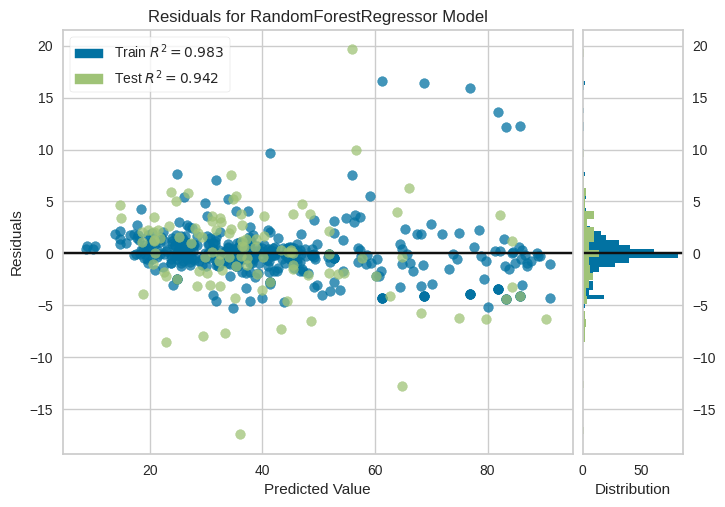

<Figure size 4000x2750 with 0 Axes>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from pyswarm import pso
import matplotlib.pyplot as plt
from yellowbrick.regressor import ResidualsPlot

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/ML works/dataset recycled aggregate natural fiber.csv')

# Clean the data by dropping rows with NaN values
df_clean = df.dropna()

# Select features and target, including the 'Fiber Type' feature
X = df_clean[['Cem', 'W/B', 'FA', 'CA',
                  'RCA', 'SCM', 'SP', 'NF',
                  'FT', 'Length', 'Age']]
y = df_clean['CS']

# One-hot encode the 'Fiber Type' feature
X = pd.get_dummies(X, columns=['FT'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function for PSO
def objective_function(params):
    n_estimators, max_depth = params
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)

    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return -r2_score(y_test, y_pred)  # negative because PSO minimizes the function

# Define the bounds for the hyperparameters
bounds = [(10, 500), (1, 50)]

# Perform PSO to find the best hyperparameters
best_params, _ = pso(objective_function, lb=[b[0] for b in bounds], ub=[b[1] for b in bounds], swarmsize=10, maxiter=50)

# Train the RandomForest model with the optimized hyperparameters
best_n_estimators = int(best_params[0])
best_max_depth = int(best_params[1])
model = RandomForestRegressor(n_estimators=best_n_estimators, max_depth=best_max_depth, random_state=42)
model.fit(X_train, y_train)

# Predict the compressive strength
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate the R^2 value
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print(f'R^2 value (Train): {r2_train}')
print(f'R^2 value (Test): {r2_test}')
print(f'N estimator: {best_n_estimators}')
print(f'Max depth: {best_max_depth}')
print(f'N estimator, max depth limit: {bounds}')
# Visualize residuals
visualizer = ResidualsPlot(model)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
plt.figure(dpi=500)
visualizer.show()

# Prepare data for CSV output with data points
train_data = pd.DataFrame({
    'Data Points (Train)': range(len(y_train)),
    'Observed (Train)': y_train.values,
    'Predicted (Train)': y_train_pred,
    'Error (Train)': y_train.values - y_train_pred
})

test_data = pd.DataFrame({
    'Data Points (Test)': range(len(y_test)),
    'Observed (Test)': y_test.values,
    'Predicted (Test)': y_test_pred,
    'Error (Test)': y_test.values - y_test_pred
})

# Save to CSV
train_data.to_csv('train_predictions_rf.csv', index=False)
test_data.to_csv('test_predictions_rf.csv', index=False)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score

# Mean Absolute Error
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f"Mean Absolute Error (Train): {mae_train}")
print(f"Mean Absolute Error (Test): {mae_test}")

# Mean Squared Error
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print(f"Mean Squared Error (Train): {mse_train}")
print(f"Mean Squared Error (Test): {mse_test}")

# Root Mean Squared Error
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
print(f"Root Mean Squared Error (Train): {rmse_train}")
print(f"Root Mean Squared Error (Test): {rmse_test}")

# Explained Variance Score (which is equivalent to R^2 Score here)
explained_variance_train = explained_variance_score(y_train, y_train_pred)
explained_variance_test = explained_variance_score(y_test, y_test_pred)
print(f"R^2 Score: {explained_variance_train}")
print(f"R^2 Score: {explained_variance_test}")

Mean Absolute Error (Train): 1.4830185270315912
Mean Absolute Error (Test): 3.1721766993145
Mean Squared Error (Train): 6.66237479480473
Mean Squared Error (Test): 20.082356960652643
Root Mean Squared Error (Train): 2.5811576462519157
Root Mean Squared Error (Test): 4.481334283520104
R^2 Score: 0.9827570928531189
R^2 Score: 0.9420186872220128


In [ ]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Calculate Standard Deviation of the errors
errors = y_test - y_test_pred
sd = np.std(errors)

# Calculate the uncertainty U_95
U_95 = 1.96 * np.sqrt(sd**2 + rmse**2)

print(f"RMSE: {rmse}")
print(f"Standard Deviation (SD) of errors: {sd}")
print(f"Uncertainty (U_95): {U_95}")

RMSE: 4.481334283520104
Standard Deviation (SD) of errors: 4.481328077855678
Uncertainty (U_95): 12.421616293102907


100%|██████████| 100/100 [00:21<00:00,  4.63it/s]


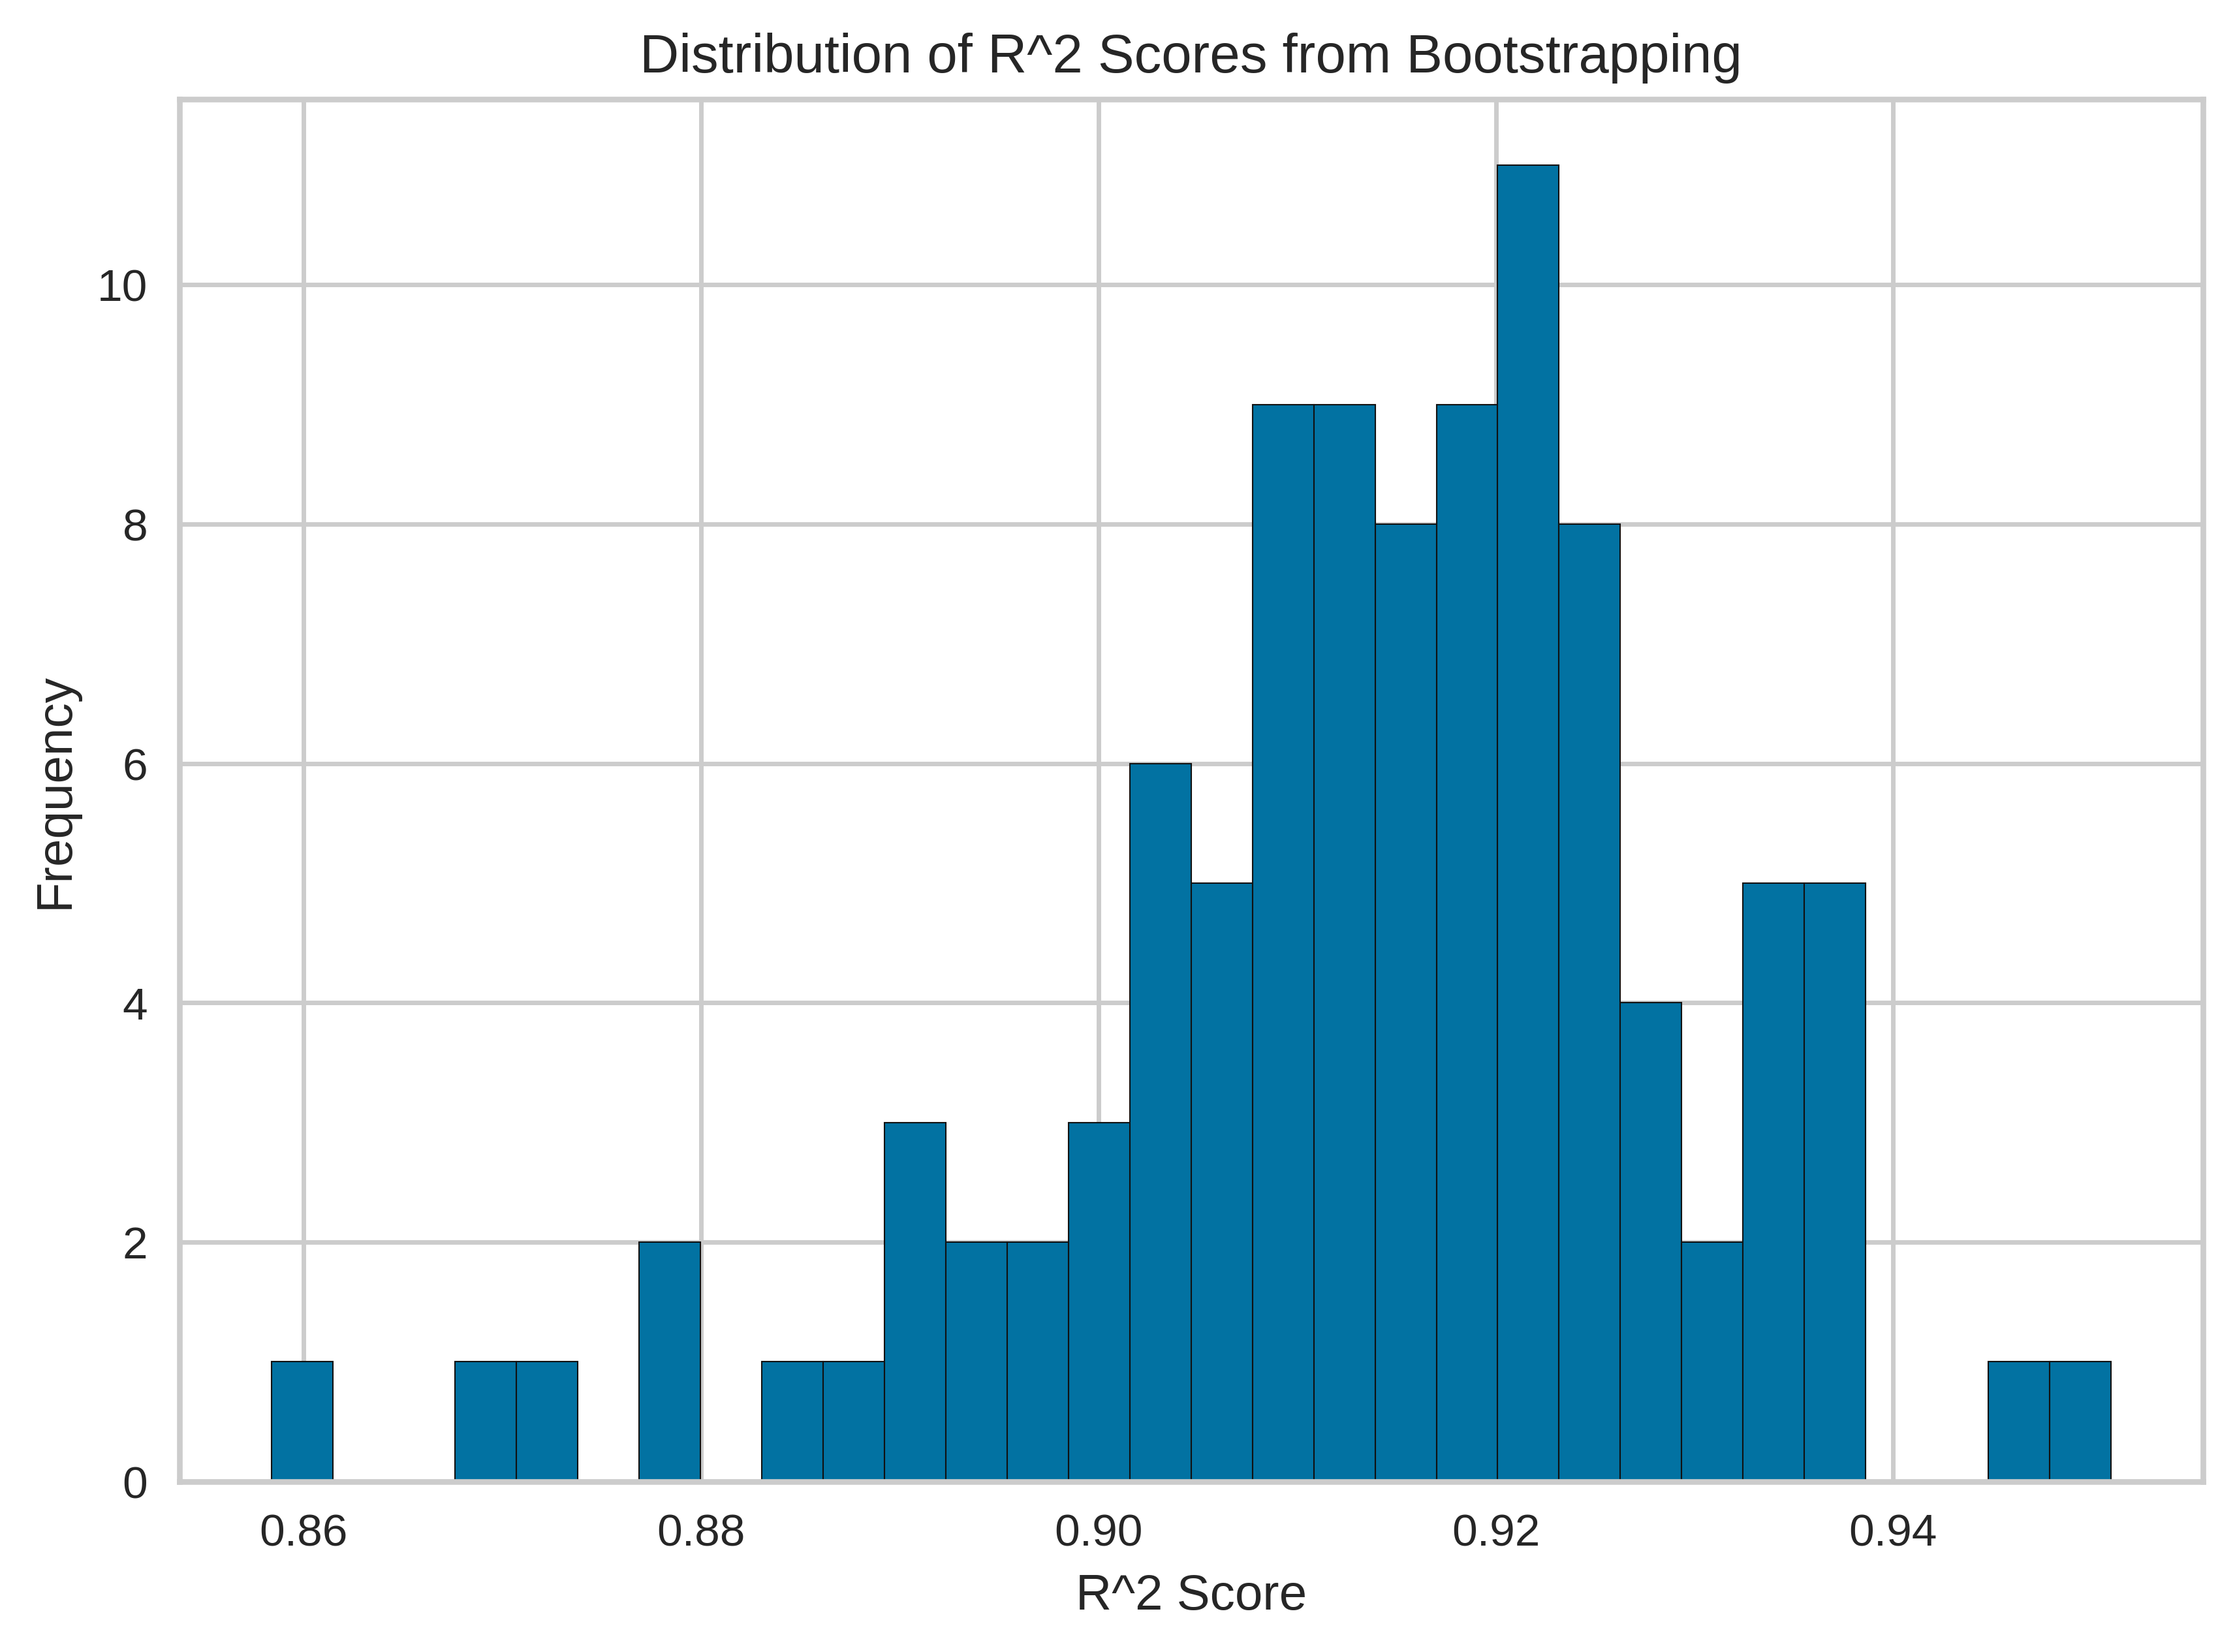

R^2 mean: 0.9136264866040602
R^2 standard deviation: 0.015946719597684914
R^2 95% confidence interval: (0.8823709161925978, 0.9448820570155226)
Uncertainty Percentage: 1.75%


In [ ]:
from sklearn.utils import resample
from tqdm import tqdm
# Uncertainty analysis using bootstrapping
n_iterations = 100  # Number of bootstrap iterations
r2_scores = []

for i in tqdm(range(n_iterations)):
    # Bootstrap sampling
    X_resampled, y_resampled = resample(X_train, y_train, random_state=i)
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test)
    r2_scores.append(r2_score(y_test, y_pred))

# Plot the distribution of R^2 scores
plt.figure(dpi=500)
plt.hist(r2_scores, bins=30, edgecolor='k')
plt.xlabel('R^2 Score')
plt.ylabel('Frequency')
plt.title('Distribution of R^2 Scores from Bootstrapping')
plt.show()

# Calculate the mean and confidence intervals
r2_mean = np.mean(r2_scores)
r2_std = np.std(r2_scores)
confidence_interval = (r2_mean - 1.96 * r2_std, r2_mean + 1.96 * r2_std)

# Calculate the uncertainty percentage
uncertainty_percentage = (r2_std / r2_mean) * 100

# Print the uncertainty values
print(f'R^2 mean: {r2_mean}')
print(f'R^2 standard deviation: {r2_std}')
print(f'R^2 95% confidence interval: {confidence_interval}')
print(f'Uncertainty Percentage: {uncertainty_percentage:.2f}%')